
# N170 Decoding

This example runs a set of machine learning algorithms on the N170 faces/houses 
dataset, and compares them in terms of classification performance. 

The data used is exactly the same as in the N170 `load_and_visualize` example. 


## Setup



In [1]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.analysis_utils import load_data
from eegnb.datasets import fetch_dataset

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

## Load Data

( See the n170 `load_and_visualize` example for further description of this)




In [2]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    
n170_data_path = os.path.join(eegnb_data_path, 'visual-N170', 'eegnb_examples')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(n170_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-N170', site='eegnb_examples')        

subject = 1
session = 1
raw = load_data(subject,session,
                experiment='visual-N170', site='eegnb_examples', device_name='muse2016',
                data_dir = eegnb_data_path)



Loading these files: 

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.30.01.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.32.50.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.35.26.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.40.17.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.42.33.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.45.08.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'st

['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Marking edge at 30732 samples (maps to 120.047 sec)
Marking edge at 61464 sample

## Filteriing



In [3]:
raw.filter(1,30, method='iir')

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<RawArray | 6 x 184380 (720.2 s), ~8.5 MiB, data loaded>

## Epoching



In [4]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True,
                verbose=False, picks=[0,1,2,3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

Finding events on: stim
1174 events found on stim channel stim
Event IDs: [1 2]
sample drop %:  4.003407155025551


<Epochs | 1127 events (all good), -0.102 – 0.801 s (baseline off), ~8.0 MiB, data loaded,
 'House': 565
 'Face': 562>

## Implement the CNN

In [5]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def basic_block(x, filters, kernel_size=(1,3), use_relu=True):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    if use_relu:
        x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    if use_relu:
        x = Activation('relu')(x)
    return x

def create_deep_resnet_eeg(nb_classes=2, Chans=4, Samples=232, filters=32):
    inputs = Input(shape=(Chans, Samples, 1))

    # Initial conv + pool
    x = Conv2D(filters, (1,7), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(1,2))(x)

    # Residual block stack
    for _ in range(4):
        x = basic_block(x, filters)
    x = Conv2D(filters*2, (1,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for _ in range(3):
        x = basic_block(x, filters*2)

    # Residual block stack at higher channel capacity
    x = Conv2D(filters*4, (1,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for _ in range(3):
        x = basic_block(x, filters*4)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [6]:
from scikeras.wrappers import KerasClassifier

def new_model_fn(nb_classes=2, Chans=4, Samples=232):
    return create_deep_resnet_eeg(nb_classes=nb_classes, Chans=Chans, Samples=Samples)


## Run classification



In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

clfs = OrderedDict()
clfs['DeepResNetEEG'] = KerasClassifier(
    build_fn=new_model_fn,
    model__nb_classes=2,
    epochs=50,
    batch_size=8,
    verbose=1
)
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
y = epochs.events[:, -1]

X_dl = X[..., np.newaxis]
y_dl = y - 1

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

auc = []
methods = []

for m in clfs:
    print(f"Running {m}...")
    if m == 'DeepResNetEEG':
        X_use, y_use = X_dl, y_dl
    else:
        X_use, y_use = X, (y==2)

    for fold, (train_idx, test_idx) in enumerate(cv.split(X_use, y_use), 1):
        print(f"  Fold {fold}...")
        X_train, X_test = X_use[train_idx], X_use[test_idx]
        y_train, y_test = y_use[train_idx], y_use[test_idx]

        try:
            if m == 'DeepResNetEEG':
                history = clfs[m].fit(X_train, y_train)
                y_pred = clfs[m].predict(X_test)
                score = accuracy_score(y_test, y_pred)
            else:
                clfs[m].fit(X_train, y_train)
                score = roc_auc_score(y_test, clfs[m].predict_proba(X_test)[:,1])

            print(f"    Fold {fold} score: {score:.3f}")
            auc.append(score)
            methods.append(m)
        except Exception as e:
            print(f"Error in fold {fold} for {m}: {e}")


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Running DeepResNetEEG...
  Fold 1...
Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 57s 305ms/step - accuracy: 0.4627 - loss: 0.7657
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.4923 - loss: 0.7316
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.5136 - loss: 0.7311
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.5408 - loss: 0.7016
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.5515 - loss: 0.6959
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.5124 - loss: 0.7095
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5314 - loss: 0.6984
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.4923 - loss: 0.7163
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.5231 - loss: 0.6971
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.5219 - loss: 0.

## Plot Decoding Results



In [10]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                 mean    std    max
Method                             
DeepResNetEEG   0.507  0.018  0.525
ERPCov + MDM    0.683  0.015  0.698
ERPCov + TS     0.697  0.029  0.726
Vect + LR       0.650  0.022  0.672
Vect + RegLDA   0.663  0.027  0.690
XdawnCov + MDM  0.656  0.016  0.672
XdawnCov + TS   0.700  0.029  0.729


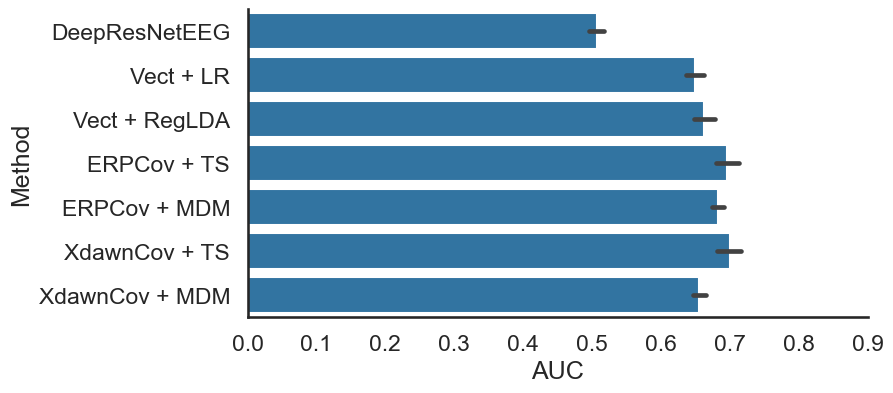

In [12]:
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.0, 0.9)
sns.despine()